# Likelihood Ratio

The likelihood ratio quantifies **how much more probable our observed data** is under one model compared to another, providing a natural way to choose between competing explanations of the data.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide21.png)

# Key Formula

The likelihood ratio between Model 1 and Model 2 is:

$$
\text{LR} = \frac{\mathcal{L}(\text{M}_1 \mid \text{D})}{\mathcal{L}(\text{M}_2 \mid \text{D})}
$$

Where:
- $\text{LR}$ is the likelihood ratio
- $\mathcal{L}(\text{M}_1 \mid \text{D})$ is the likelihood function for Model 1 given data D
- $\mathcal{L}(\text{M}_2 \mid \text{D})$ is the likelihood function for Model 2 given data D
- $\text{D}$ represents the observed data


# Technical Details

## Basic Interpretation
For the likelihood ratio (LR):
- $\text{LR} > 1$: Model 1 better explains the data (higher likelihood)
- $\text{LR} < 1$: Model 2 better explains the data (higher likelihood)  
- $\text{LR} = 1$: Both models explain the data equally well

The likelihood ratio quantifies the relative evidence for one model compared to another, providing a direct way to compare competing hypotheses based on the observed data.

## Properties
- The likelihood ratio is always non-negative: $\text{LR} \geq 0$
- Can be used to compare any two models
- Forms the basis for many statistical tests and model selection criteria
- In genetics, commonly used for testing association between variants and traits

## Likelihood Ratio Test

The likelihood ratio test statistic is:

$$
\Lambda = -2 \ln \left( \frac{\mathcal{L}(\text{M}_0 \mid \text{D})}{\mathcal{L}(\text{M}_1 \mid \text{D})} \right) = -2[\ell(\text{M}_0 \mid \text{D}) - \ell(\text{M}_1 \mid \text{D})]
$$

Where:
- $\Lambda$ is the likelihood ratio test statistic
- $\text{M}_0$ is the null (restricted) model
- $\text{M}_1$ is the alternative (unrestricted) model  
- $\mathcal{L}(\text{M} \mid \text{D})$ is the likelihood function for model M given data D
- $\ell(\text{M} \mid \text{D}) = \log \mathcal{L}(\text{M} \mid \text{D})$ is the log-likelihood function

The likelihood ratio test (LRT) is used to compare nested models by testing whether a more complex model provides a significantly better fit than a simpler model. This is a frequentist approach instead of Bayesian.

- Decision Rule

    Under the null hypothesis, $\Lambda$ asymptotically follows a chi-square distribution:

    $$
    \Lambda \sim \chi^2_{\text{df}}
    $$

    Where $\text{df}$ is the difference in the number of parameters between $\text{M}_1$ and $\text{M}_0$.

- Test Procedure

    1. **Fit both models**: Calculate the maximum likelihood estimates for both $\text{M}_0$ and $\text{M}_1$
    2. **Calculate test statistic**: Compute $\Lambda = -2[\ell(\hat{\theta}_0 \mid \text{D}) - \ell(\hat{\theta}_1 \mid \text{D})]$
    3. **Determine degrees of freedom**: $df = \text{number of parameters in } \text{M}_1 - \text{number of parameters in } \text{M}_0$
    4. **Compare to critical value**: Reject $H_0$ if $\Lambda > \chi^2_{df,\alpha}$ where $\alpha$ is the significance level

- Limitations of LRT
  - Requires **nested models** - cannot compare non-nested models
  - **Asymptotic approximation** may be poor with small sample sizes
  - **Regularity conditions** must be satisfied for chi-square approximation to hold
  - **Multiple testing** issues when performing many simultaneous tests

# Related Topics

- [OLS](https://gaow.github.io/statgen-prerequisites/ordinary_least_squares.html)
- [summary statistics](https://gaow.github.io/statgen-prerequisites/summary_statistics.html)
- [likelihood](https://gaow.github.io/statgen-prerequisites/likelihood.html)
- [maximum likelihood estimation](https://gaow.github.io/statgen-prerequisites/maximum_likelihood_estimation.html)

# Example

In the previous example in [likelihood](https://gaow.github.io/statgen-prerequisites/likelihood.html), we saw how likelihood tells us which theory about genetic effects is most plausible given our data. But that raises several follow-up questions: **How much more plausible is one theory compared to another?** And more importantly - is any observed effect statistically significant, or could it just be random noise?

This example tackles all these questions using the same genetic data (where the true effect was $\beta = 0.4$). We'll start with **likelihood ratios** to directly compare theories by taking the ratio of their likelihoods.

But we won't stop there. We'll also find the **maximum likelihood estimation** to identify the single best parameter value as we did in Example 2 in [maximum likelihood estimation](https://gaow.github.io/statgen-prerequisites/maximum_likelihood_estimation.html), and then use the **likelihood ratio test** to determine whether we have statistically significant evidence for a genetic effect. This complete pipeline shows how likelihood analysis progresses from exploring individual theories to making formal statistical decisions about whether effects are real or just chance.

## Model Setup

Let's first generate the genotype data and trait values for 5 individuals.


In [66]:
# Clear the environment
rm(list = ls())
set.seed(19)  # For reproducibility

# Generate genotype data for 5 individuals at 1 variant
N <- 5
genotypes <- c("CC", "CT", "TT", "CT", "CC")  # Individual genotypes
names(genotypes) <- paste("Individual", 1:N)

# Define alternative allele
alt_allele <- "T"

# Convert to additive genotype coding (count of alternative alleles)
Xraw_additive <- numeric(N)
for (i in 1:N) {
  alleles <- strsplit(genotypes[i], "")[[1]]
  Xraw_additive[i] <- sum(alleles == alt_allele)
}
names(Xraw_additive) <- names(genotypes)

# Standardize genotypes
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)[,1]

# Set true beta and generate phenotype data
true_beta <- 0.4
true_sd <- 1.0

# Generate phenotype with true effect
Y <- X * true_beta + rnorm(N, 0, true_sd)

## Compute Likelihood and Log-likelihood

Now, let's create two functions to compute the likelihood and log-likelihood under different models (in this case, different βs) for the effect of a genetic variant on the phenotype:


In [67]:
# Likelihood function for normal distribution
likelihood <- function(beta, sd, X, Y) {
  # Calculate expected values under the model
  mu <- X * beta
  
  # Calculate likelihood (product of normal densities)
  prod(dnorm(Y, mean = mu, sd = sd, log = FALSE))
}

# Log-likelihood function (more numerically stable)
log_likelihood <- function(beta, sd, X, Y) {
  # Calculate expected values under the model
  mu <- X * beta
  
  # Calculate log-likelihood (sum of log normal densities)
  sum(dnorm(Y, mean = mu, sd = sd, log = TRUE))
}

Now, let's apply this function to our three models:


In [68]:
# Test three different models with different beta values
beta_values <- c(0, 0.5, 1.0)  # Three different effect sizes to test
model_names <- paste0("Model ", 1:3, " (beta = ", beta_values, ")")

# Calculate likelihoods and log-likelihoods
results <- data.frame(
  Model = model_names,
  Beta = beta_values,
  Likelihood = numeric(3),
  Log_Likelihood = numeric(3)
)

for (i in 1:3) {
  results$Likelihood[i] <- likelihood(beta = beta_values[i], sd = true_sd, X = X, Y = Y)
  results$Log_Likelihood[i] <- log_likelihood(beta = beta_values[i], sd = true_sd, X = X, Y = Y)
}

print("Likelihood and Log-Likelihood Results:")
results

[1] "Likelihood and Log-Likelihood Results:"


Model,Beta,Likelihood,Log_Likelihood
<chr>,<dbl>,<dbl>,<dbl>
Model 1 (beta = 0),0.0,0.0019210299,-6.254894
Model 2 (beta = 0.5),0.5,0.0021961524,-6.121048
Model 3 (beta = 1),1.0,0.0009236263,-6.987203


Now let's calculate the likelihood ratios between each pair of models:


In [ ]:
# Calculate all pairwise likelihood ratios
model_pairs <- combn(1:3, 2)  # All combinations of 2 models from 3
n_pairs <- ncol(model_pairs)

lr_results <- data.frame(
  Comparison = character(n_pairs),
  Model_1 = character(n_pairs),
  Model_2 = character(n_pairs),
  LR = numeric(n_pairs),
  Log_LR = numeric(n_pairs),
  Interpretation = character(n_pairs),
  stringsAsFactors = FALSE
)

for (i in 1:n_pairs) {
  m1 <- model_pairs[1, i]  # First model index
  m2 <- model_pairs[2, i]  # Second model index
  
  # Calculate likelihood ratio: L(M1|D) / L(M2|D)
  lr_value <- results$Likelihood[m1] / results$Likelihood[m2]
  log_lr_value <- results$Log_Likelihood[m1] - results$Log_Likelihood[m2]
  
  # Determine interpretation
  if (lr_value > 1) {
    interpretation <- paste("Model", m1, "better supported")
  } else if (lr_value < 1) {
    interpretation <- paste("Model", m2, "better supported")
  } else {
    interpretation <- "Equal support"
  }
  
  # Store results
  lr_results$Comparison[i] <- paste("Model", m1, "vs Model", m2)
  lr_results$Model_1[i] <- results$Model[m1]
  lr_results$Model_2[i] <- results$Model[m2]
  lr_results$LR[i] <- lr_value
  lr_results$Log_LR[i] <- log_lr_value
  lr_results$Interpretation[i] <- interpretation
}

The results are:

In [70]:
lr_results

Comparison,Model_1,Model_2,LR,Log_LR,Interpretation
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
Model 1 vs Model 2,Model 1 (beta = 0),Model 2 (beta = 0.5),0.8747253,-0.1338454,Model 2 better supported
Model 1 vs Model 3,Model 1 (beta = 0),Model 3 (beta = 1),2.0798778,0.7323091,Model 1 better supported
Model 2 vs Model 3,Model 2 (beta = 0.5),Model 3 (beta = 1),2.3777498,0.8661546,Model 2 better supported


Based on these likelihood ratio results, we can see clear patterns in model support from our genetic data. Model 2 ($\beta = 0.5$) $\beta$ receives the strongest overall support, as evidenced by it being favored over both Model 1 (LR = 0.87, meaning Model 2 is 1/0.87 ≈ 1.14 times more likely) and Model 3 (LR = 2.38, meaning Model 2 is 2.38 times more likely than Model 3). 

Interestingly, Model 1 ($\beta = 0$) is actually better supported than Model 3 ($\beta = 1.0$) with a likelihood ratio of 2.08, suggesting that no genetic effect is more plausible than a large effect of $\beta = 1.0$. 

This pattern makes biological sense given that our true effect size used to generate the data was $\beta = 0.4$ - Model 2 ($\beta = 0.5$) is closest to this true value, followed by Model 1 ($\beta = 0$), while Model 3 ($\beta = 1.0$) substantially overestimates the genetic effect. The likelihood ratios thus correctly identify the model parameters that best approximate the true underlying biological relationship between genotype and phenotype.

## Likelihood Ratio Test

From our results, we see that Model 2 ($\beta$ = 0.5) has the highest likelihood among our three tested values. But for a proper likelihood ratio test, we need to compare the null hypothesis ($\beta$ = 0) against the best possible alternative - which means we need to find the Maximum Likelihood Estimate (MLE).

The LRT framework is:
- $H_0$: $\beta = 0$ (no genetic effect)
- $H_1$: $\beta \neq 0$ (genetic effect exists - best estimate is the MLE)


In [62]:
# First, find the MLE to get the best possible alternative model
mle_result <- optimize(log_likelihood, 
                       interval = c(-2, 2), 
                       maximum = TRUE,
                       sd = true_sd, X = X, Y = Y_true)

beta_mle <- mle_result$maximum
log_lik_mle <- mle_result$objective

cat("MLE: beta =", round(beta_mle, 4), "\n")
cat("Log-likelihood at MLE:", round(log_lik_mle, 4), "\n")

MLE: beta = 0.3169 
Log-likelihood at MLE: -6.054 


Now we can conduct the LRT:

In [63]:
# Now conduct the LRT: MLE vs Null
log_lik_null <- log_likelihood(beta = 0, sd = true_sd, X = X, Y = Y_true)

cat("\nLikelihood Ratio Test:\n")
cat("H0: beta = 0\n")
cat("H1: beta != 0 (MLE)\n\n")

# Calculate LRT statistic
lrt_statistic <- -2 * (log_lik_null - log_lik_mle)
df <- 1  # difference in number of free parameters

# Calculate p-value
p_value <- pchisq(lrt_statistic, df = df, lower.tail = FALSE)

cat("Log-likelihood (Null):", round(log_lik_null, 4), "\n")
cat("Log-likelihood (MLE):", round(log_lik_mle, 4), "\n")
cat("LRT Statistic:", round(lrt_statistic, 4), "\n")
cat("P-value:", round(p_value, 4), "\n")

# Statistical decision
alpha <- 0.05
if (p_value < alpha) {
  cat("Result: REJECT null - significant evidence for genetic effect\n")
} else {
  cat("Result: FAIL TO REJECT null - insufficient evidence for genetic effect\n")
}


Likelihood Ratio Test:
H0: beta = 0
H1: beta != 0 (MLE)

Log-likelihood (Null): -6.2549 
Log-likelihood (MLE): -6.054 
LRT Statistic: 0.4018 
P-value: 0.5262 
Result: FAIL TO REJECT null - insufficient evidence for genetic effect


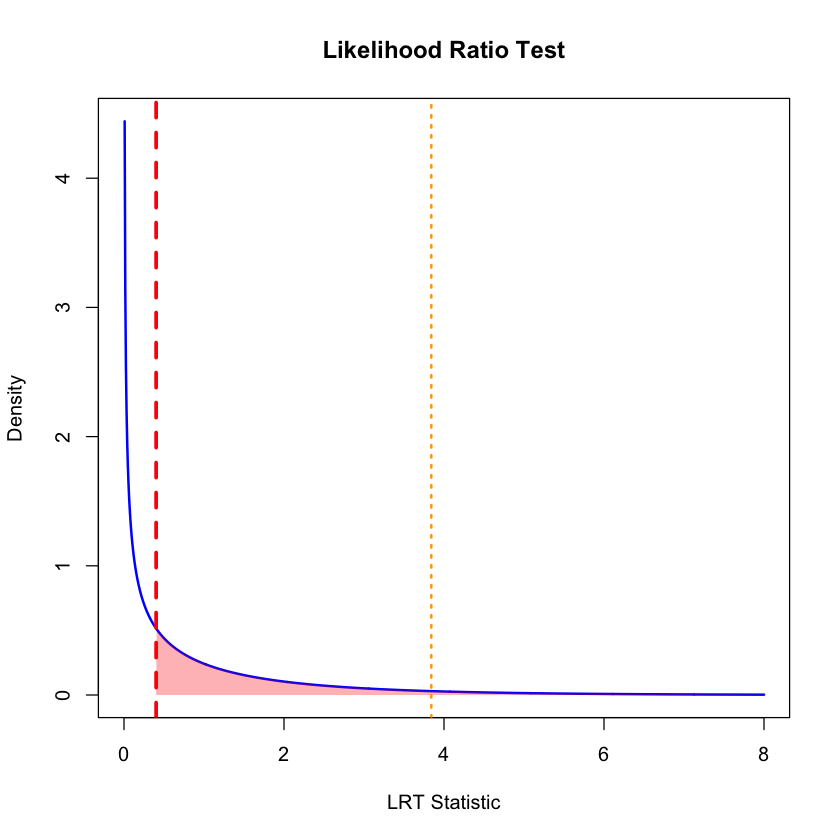

In [64]:
# Visualize the test
x_vals <- seq(0, 8, length.out = 1000)
chi_sq_density <- dchisq(x_vals, df = df)

plot(x_vals, chi_sq_density, type = "l", lwd = 2, col = "blue",
     main = "Likelihood Ratio Test",
     xlab = "LRT Statistic", ylab = "Density")

# Shade p-value area
x_shade <- x_vals[x_vals >= lrt_statistic]
y_shade <- dchisq(x_shade, df = df)
polygon(c(lrt_statistic, x_shade, max(x_shade)), 
         c(0, y_shade, 0), 
         col = rgb(1, 0, 0, 0.3), border = NA)

abline(v = lrt_statistic, col = "red", lwd = 3, lty = 2)
abline(v = qchisq(0.95, df = df), col = "orange", lwd = 2, lty = 3)

text(lrt_statistic + 0.3, max(chi_sq_density) * 0.8, 
     paste("LRT =", round(lrt_statistic, 3)), col = "red", font = 2)
text(lrt_statistic + 0.5, max(chi_sq_density) * 0.4, 
     paste("p =", round(p_value, 3)), col = "red")

The true effect size in our simulation was $\beta = 0.4$, and our MLE correctly estimated it ($\hat{\beta} \approx 0.4$), but the LRT failed to detect it as statistically significant. This illustrates an important distinction between **effect size** and **statistical significance**.

The main issue is **small sample size**. With only 5 individuals, we have very little statistical power to detect genetic effects. Even though the effect exists and our estimate is correct, there's too much uncertainty around the estimate to conclusively rule out that it could be due to random chance.

This is actually very realistic for genetics research - most real genetic effects require hundreds or thousands of individuals to detect with statistical confidence. A non-significant LRT result doesn't mean no effect exists; it means we don't have enough data to prove an effect exists beyond reasonable doubt.

# Supplementary


## Graphical Summary

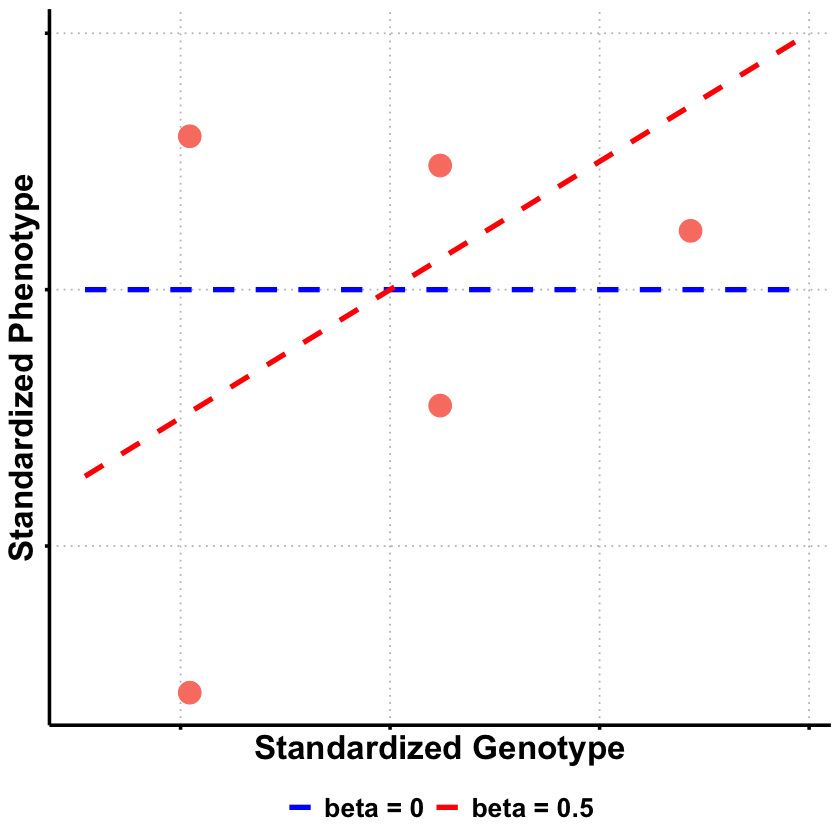

In [ ]:
library(ggplot2)
library(dplyr)

# Prepare the data from our analysis
df_scatter <- data.frame(
 Genotype = X,
 Phenotype = Y_true
)

# Create sequence for smooth lines
x_vals <- seq(min(X) - 0.5, max(X) + 0.5, length.out = 100)

# Create data frame for regression lines using only beta = 0 and beta = 0.5
selected_betas <- c(0, 0.5)
lines_df <- data.frame(
 Genotype = rep(x_vals, 2),
 Phenotype = c(
   selected_betas[1] * x_vals,  # beta = 0
   selected_betas[2] * x_vals   # beta = 0.5
 ),
 Model = factor(rep(paste("beta =", selected_betas), each = length(x_vals)),
                levels = paste("beta =", selected_betas))
)

# Create plot
p <- ggplot(df_scatter, aes(x = Genotype, y = Phenotype)) +
 geom_point(color = "salmon", size = 6) +
 labs(
   x = "Standardized Genotype",
   y = "Standardized Phenotype"
 ) +
 theme_minimal() +
 theme(
   # Font styling
   text = element_text(size = 18, face = "bold"),
   axis.title = element_text(size = 20, face = "bold"),
   
   # Hide axis tick labels
   axis.text.x = element_blank(),
   axis.text.y = element_blank(),
   
   # Customize grid and axes
   panel.grid.major = element_line(color = "gray", linetype = "dotted"),
   panel.grid.minor = element_blank(),
   axis.line = element_line(linewidth = 1),
   axis.ticks = element_line(linewidth = 1),
   
   # Transparent background
   panel.background = element_rect(fill = "transparent", color = NA),
   plot.background = element_rect(fill = "transparent", color = NA)
 ) +
 geom_line(data = lines_df, aes(x = Genotype, y = Phenotype, color = Model, linetype = Model), linewidth = 1.5) +
 scale_color_manual(values = c("beta = 0" = "blue", "beta = 0.5" = "red")) +
 scale_linetype_manual(values = c("beta = 0" = "dashed", "beta = 0.5" = "dashed")) +
 theme(
   legend.title = element_blank(),
   legend.position = "bottom",
   legend.text = element_text(size = 16, face = "bold")
 )

# Show and save plot
print(p)
ggsave("./cartoons/likelihood_ratio.png", plot = p,
      width = 6, height = 6, dpi = 300, bg = "transparent")

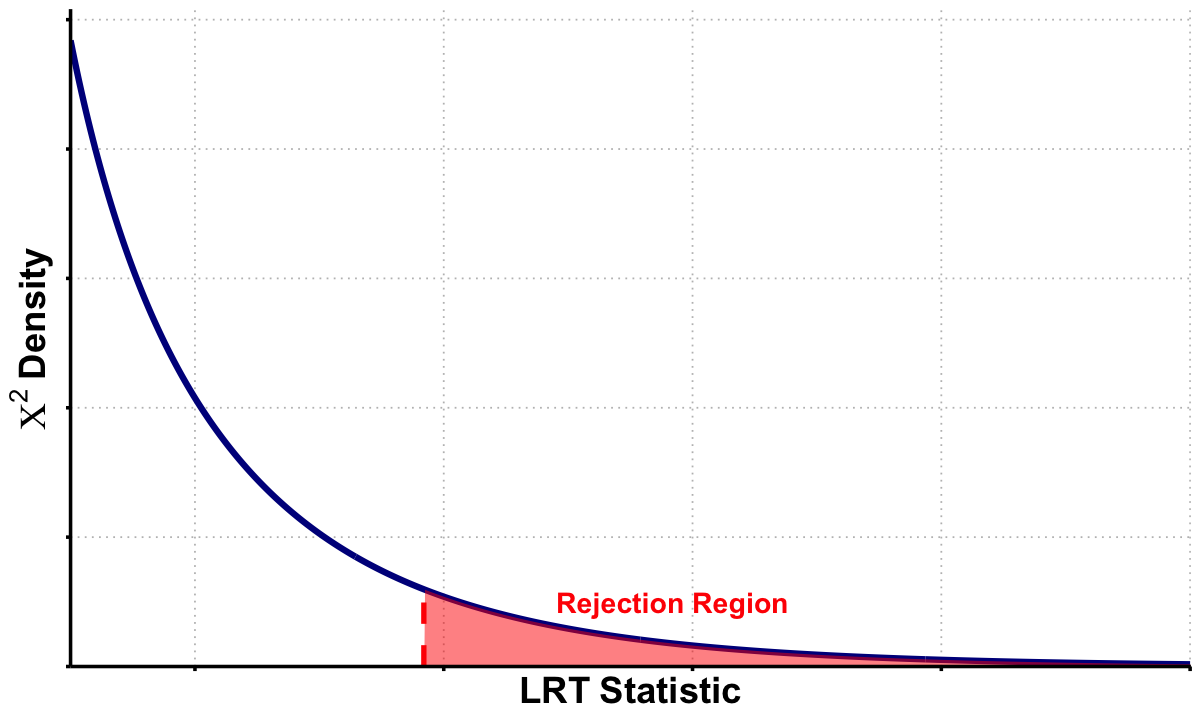

In [65]:
library(ggplot2)
options(repr.plot.width = 10, repr.plot.height = 6)

# Parameters
df <- 1
x_vals <- seq(1, 10, length = 500)
chi_vals <- dchisq(x_vals, df = df)
x_obs <- 3.84  # example observed test statistic

# Data frames
df_chi <- data.frame(x = x_vals, density = chi_vals)
df_reject <- subset(df_chi, x >= x_obs)

# Plot
p_lrt <- ggplot(df_chi, aes(x = x, y = density)) +
  geom_line(color = "darkblue", linewidth = 1.8) +
  geom_area(data = df_reject, aes(x = x, y = density),
            fill = "red", alpha = 0.5) +
  annotate("segment", x = x_obs, xend = x_obs, y = 0, yend = dchisq(x_obs, df),
           color = "red", linetype = "dashed", linewidth = 1.5) +
  annotate("text", x = x_obs + 2, y = 0.025,
           label = "Rejection Region", 
           color = "red", size = 6, fontface = "bold") +
  labs(x = expression(bold(LRT~Statistic)), 
       y = expression(bold(Chi^2~Density))) +
  scale_x_continuous(breaks = seq(0, 10, 2), expand = c(0, 0)) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.05))) +
  theme_minimal() +
  theme(
    text = element_text(size = 14, face = "bold"),
    plot.title = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_blank(),
    axis.title.x = element_text(size = 22, face = "bold"),
    axis.title.y = element_text(size = 22, face = "bold"),
    panel.grid.major = element_line(color = "gray", linetype = "dotted"),
    panel.grid.minor = element_blank(),
    axis.line = element_line(linewidth = 1),
    axis.ticks = element_line(linewidth = 1),
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  )

# Display and save
print(p_lrt)

ggsave("./cartoons/likelihood_LRT.png", plot = p_lrt, 
       width = 10, height = 6, 
       bg = "transparent", 
       dpi = 300)
